# Random Forest and Gradient Boosting Prediction Intervals 

# setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
boston = load_boston()
features = boston["data"]
feature_names = boston["feature_names"]
labels = boston["target"]

In [4]:
df = pd.DataFrame(features)
df.columns = feature_names 
df["LABEL"] = labels

In [5]:
X = df.drop(columns=["LABEL"])
y = df["LABEL"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# random forest 

In [7]:
# https://blog.datadive.net/prediction-intervals-for-random-forests/

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
clf = RandomForestRegressor(n_estimators=500, 
                            max_features=0.5,
                            min_samples_leaf=1, 
                            n_jobs=-1, 
                            oob_score=True)

In [10]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [11]:
# predictions

In [12]:
clf_predictions = clf.predict(X_test)

In [13]:
# metrics 

In [14]:
print(f"Training R^2: {clf.score(X_train, y_train)}")

Training R^2: 0.9831956027550519


In [15]:
print(f"Testing R^2: {clf.score(X_test, y_test)}")

Testing R^2: 0.9086902949522201


In [16]:
print(f"OOB Score: {clf.oob_score_}")

OOB Score: 0.8767155335949873


Text(0.5, 1.0, 'Actual vs. Prediction')

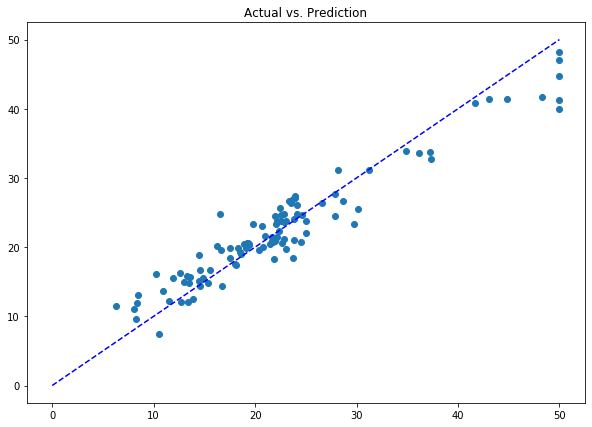

In [17]:
plt.figure(figsize=[10,7])
plt.scatter(y_test, clf_predictions)
plt.plot([0,50],[0,50], 'b--')
plt.title("Actual vs. Prediction")

In [18]:
# prediction intervals 

In [19]:
def prediction_intervals(model, X, percentile):
    predictions = np.array([pred.predict(X) for pred in model.estimators_])
    err_down = np.apply_along_axis(lambda x: np.percentile(x, (100 - percentile) / 2.), 0, predictions)
    err_up = np.apply_along_axis(lambda x: np.percentile(x, 100 - (100 - percentile) / 2.), 0, predictions)
    return np.transpose(np.array([err_down, err_up]))

In [20]:
prediction_ints = prediction_intervals(clf, X_test, percentile=90)

In [21]:
prediction_ints_df = pd.DataFrame(prediction_ints)
prediction_ints_df.columns = ["LOWER","UPPER"]

In [22]:
# results 

In [23]:
actual_prediction_df = pd.DataFrame({'ACTUAL' : y_test,
                                     'PREDICTION' : clf_predictions}).reset_index(drop=True)
results_df = pd.concat([actual_prediction_df, prediction_ints_df], axis=1)

In [24]:
results_df

,ACTUAL,PREDICTION,LOWER,UPPER
0,28.2,31.1186,23.6,36.200
1,23.9,27.3302,22.0,33.005
2,16.6,19.6284,14.4,24.400
3,22.0,20.9560,18.2,23.710
4,20.8,19.9878,15.0,24.300
...,...,...,...,...
97,22.9,23.6502,20.6,28.100
98,44.8,41.4482,31.5,50.000
99,21.7,20.8226,18.5,23.325
100,10.2,16.1484,10.8,21.400


In [25]:
results_df.describe()

,ACTUAL,PREDICTION,LOWER,UPPER
count,102.000000,102.000000,102.000000,102.000000
mean,22.574510,22.664502,17.361324,28.550098
std,9.990289,8.314350,6.876148,10.175153
min,6.300000,7.463400,5.000000,12.300000
25%,16.275000,17.456750,13.085000,21.751250
50%,21.850000,20.889300,17.100000,24.552500
75%,24.100000,25.382150,20.600000,32.200000
max,50.000000,48.149600,37.600000,50.000000


In [26]:
# plot results

In [27]:
results_df_sorted = results_df.sort_values(by='ACTUAL').reset_index(drop=True)

(0, 60)

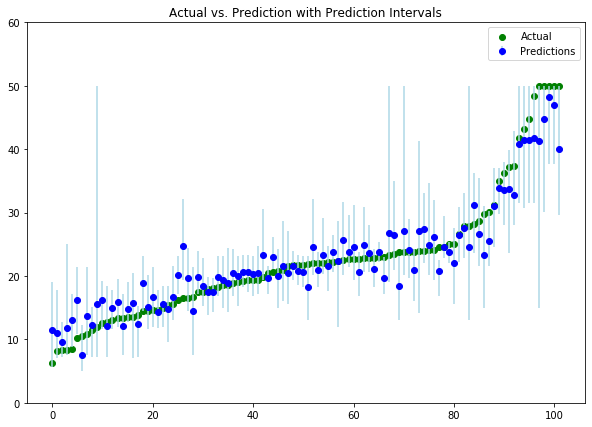

In [28]:
plt.figure(figsize=[10,7])
plt.scatter(results_df_sorted.index,
            results_df_sorted.ACTUAL,
            color='green')
plt.errorbar(results_df_sorted.index,
             results_df_sorted.PREDICTION,
             yerr=[results_df_sorted.PREDICTION - results_df_sorted.LOWER, 
                   results_df_sorted.UPPER - results_df_sorted.PREDICTION],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction with Prediction Intervals")
plt.legend(['Actual','Predictions'])
plt.ylim([0,60])

In [29]:
correct = 0
for each_row in results_df_sorted.itertuples():
    if each_row.LOWER <= each_row.ACTUAL <= each_row.UPPER:
        correct += 1
print(f"Percent of Predictions +/- Interval that Include Actual Value: {correct/results_df.shape[0]}")

Percent of Predictions +/- Interval that Include Actual Value: 0.9313725490196079


In [30]:
# other options: 
# https://github.com/scikit-learn-contrib/forest-confidence-interval - forest-confidence-interval
# https://scikit-garden.github.io/examples/QuantileRegressionForests/ - Quantile Regression Forests 
# https://github.com/grf-labs/grf - Generalized Random Forests
# https://github.com/imbs-hl/ranger - Ranger

# sklearn gbm

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

In [32]:
clf_gbm = GradientBoostingRegressor(loss='lad',
                                    learning_rate=0.25,
                                    min_samples_leaf=9, 
                                    min_samples_split=9,
                                    n_estimators=200,
                                    random_state=1)
clf_gbm.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.25, loss='lad',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
# predictions

In [34]:
clf_gbm_predictions = clf_gbm.predict(X_test)

In [35]:
# metrics 

In [36]:
print(f"Training R^2: {clf_gbm.score(X_train, y_train)}")

Training R^2: 0.9301751143196128


In [37]:
print(f"Testing R^2: {clf_gbm.score(X_test, y_test)}")

Testing R^2: 0.8982176875817872


Text(0.5, 1.0, 'Actual vs. Prediction')

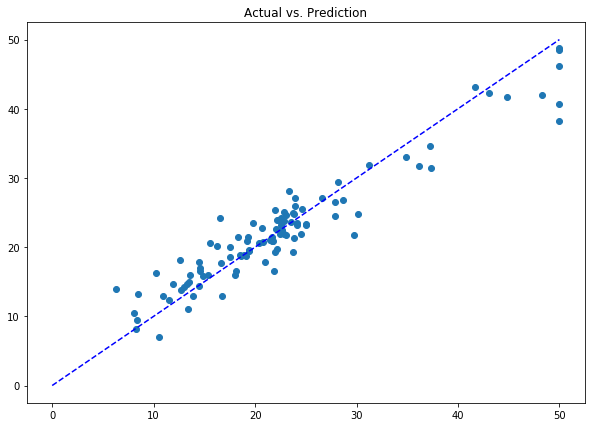

In [38]:
plt.figure(figsize=[10,7])
plt.scatter(y_test, clf_gbm_predictions)
plt.plot([0,50],[0,50], 'b--')
plt.title("Actual vs. Prediction")

In [39]:
# prediction intervals 

In [40]:
alpha = 0.975

In [41]:
clf_gbm_upper = GradientBoostingRegressor(loss='quantile', 
                                          alpha=alpha,
                                          learning_rate=0.25,
                                          min_samples_leaf=9, 
                                          min_samples_split=9,
                                          n_estimators=200,
                                          random_state=1)
clf_gbm_upper.fit(X_train, y_train)
y_upper = clf_gbm_upper.predict(X_test)

In [42]:
clf_gbm_lower = GradientBoostingRegressor(loss='quantile', 
                                          alpha=1-alpha,
                                          learning_rate=0.25,
                                          min_samples_leaf=9, 
                                          min_samples_split=9,
                                          n_estimators=200,
                                          random_state=1)
clf_gbm_lower.fit(X_train, y_train)
y_lower = clf_gbm_lower.predict(X_test)

In [43]:
# results

In [44]:
results_gbm_df = pd.DataFrame({'ACTUAL' : y_test,
                               'PREDICTION' : clf_gbm_predictions,
                               'UPPER' : y_upper,
                               'LOWER' : y_lower}).reset_index(drop=True)

In [45]:
results_gbm_df

,ACTUAL,PREDICTION,UPPER,LOWER
0,28.2,29.344403,31.180253,24.173866
1,23.9,27.079061,28.835753,24.267125
2,16.6,17.702270,22.660348,17.584184
3,22.0,19.298849,25.890126,19.325858
4,20.8,20.794504,21.988005,15.364676
...,...,...,...,...
97,22.9,25.106272,27.793616,21.224719
98,44.8,41.630003,48.515908,23.373630
99,21.7,20.897744,23.419427,17.769498
100,10.2,16.331613,22.047834,11.452114


In [46]:
# plot results

In [47]:
results_gbm_df_sorted = results_gbm_df.sort_values(by='ACTUAL').reset_index(drop=True)

(0, 60)

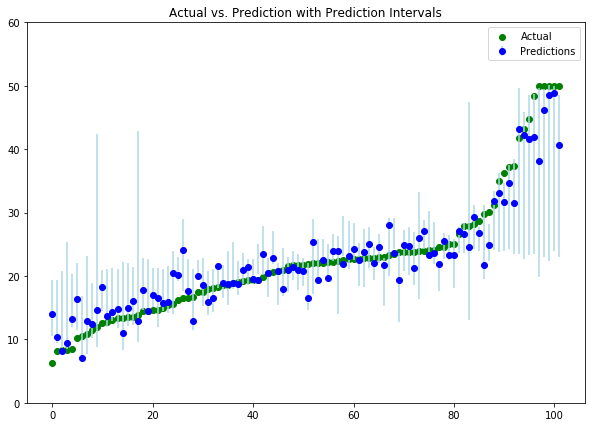

In [48]:
plt.figure(figsize=[10,7])
plt.scatter(results_gbm_df_sorted.index,
            results_gbm_df_sorted.ACTUAL,
            color='green')
plt.errorbar(results_gbm_df_sorted.index,
             results_gbm_df_sorted.PREDICTION,
             yerr=[results_gbm_df_sorted.PREDICTION - results_gbm_df_sorted.LOWER, 
                   results_gbm_df_sorted.UPPER - results_gbm_df_sorted.PREDICTION],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction with Prediction Intervals")
plt.legend(['Actual','Predictions'])
plt.ylim([0,60])

In [49]:
correct = 0
for each_row in results_gbm_df_sorted.itertuples():
    if each_row.LOWER <= each_row.ACTUAL <= each_row.UPPER:
        correct += 1
print(f"Percent of Predictions +/- Interval that Include Actual Value: {correct/results_gbm_df_sorted.shape[0]}")

Percent of Predictions +/- Interval that Include Actual Value: 0.7058823529411765


# lightgbm

In [71]:
import lightgbm

In [51]:
clf_lgbm = lightgbm.LGBMRegressor(oobjective = "regression_l1",
                                  reg_sqrt=True,
                                  max_depth=3,
                                  learning_rate=0.1,
                                  min_data_in_leaf=5,
                                  n_estimators=500,
                                  random_state=1)

In [52]:
clf_lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=5,
              min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
              objective=None, oobjective='regression_l1', random_state=1,
              reg_alpha=0.0, reg_lambda=0.0, reg_sqrt=True, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
# predictions 

In [54]:
clf_lgbm_predictions = clf_lgbm.predict(X_test)

In [55]:
# metrics 

In [56]:
print(f"Training R^2: {clf_lgbm.score(X_train, y_train)}")

Training R^2: 0.9980155718250587


In [57]:
print(f"Testing R^2: {clf_lgbm.score(X_test, y_test)}")

Testing R^2: 0.9100028680778774


Text(0.5, 1.0, 'Actual vs. Prediction')

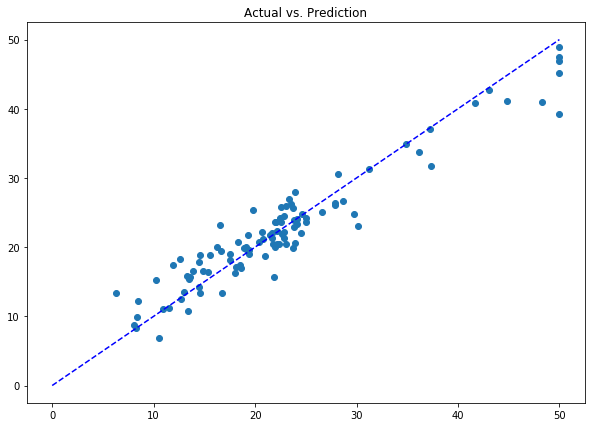

In [58]:
plt.figure(figsize=[10,7])
plt.scatter(y_test, clf_lgbm_predictions)
plt.plot([0,50],[0,50], 'b--')
plt.title("Actual vs. Prediction")

In [59]:
# prediction intervals 

In [60]:
alpha = 0.95

In [61]:
clf_lgbm_upper = lightgbm.LGBMRegressor(objective='quantile', 
                                        alpha=alpha,
                                        reg_sqrt=True,
                                        max_depth=3,
                                        learning_rate=0.1,
                                        min_data_in_leaf=5,
                                        n_estimators=500,                                       
                                        random_state=1)
clf_lgbm_upper.fit(X_train, y_train)
lgbm_y_upper = clf_lgbm_upper.predict(X_test)

In [62]:
clf_lgbm_lower = lightgbm.LGBMRegressor(objective='quantile', 
                                        alpha=1-alpha,
                                        reg_sqrt=True,
                                        max_depth=3,
                                        learning_rate=0.1,
                                        min_data_in_leaf=5,
                                        n_estimators=500,     
                                        random_state=1)
clf_lgbm_lower.fit(X_train, y_train)
lgbm_y_lower = clf_lgbm_lower.predict(X_test)

In [63]:
# results

In [64]:
results_lgbm_df = pd.DataFrame({'ACTUAL' : y_test,
                               'PREDICTION' : clf_lgbm_predictions,
                               'UPPER' : lgbm_y_upper,
                               'LOWER' : lgbm_y_lower}).reset_index(drop=True)

In [65]:
results_lgbm_df

,ACTUAL,PREDICTION,UPPER,LOWER
0,28.2,30.528815,32.665877,25.045502
1,23.9,28.002772,30.406091,24.500533
2,16.6,19.390872,24.654554,16.857341
3,22.0,19.989305,23.797818,19.689133
4,20.8,21.132097,20.420746,17.351349
...,...,...,...,...
97,22.9,24.552409,27.140044,21.824108
98,44.8,41.164675,49.946907,32.073854
99,21.7,22.018986,23.518032,18.823773
100,10.2,15.311287,21.121256,12.453773


In [66]:
# plot results

In [67]:
results_lgbm_df_sorted = results_lgbm_df.sort_values(by='ACTUAL').reset_index(drop=True)

(0, 60)

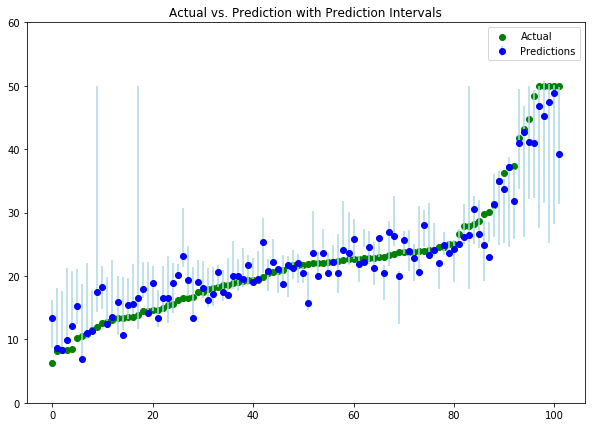

In [68]:
plt.figure(figsize=[10,7])
plt.scatter(results_lgbm_df_sorted.index,
            results_lgbm_df_sorted.ACTUAL,
            color='green')
plt.errorbar(results_lgbm_df_sorted.index,
             results_lgbm_df_sorted.PREDICTION,
             yerr=[results_lgbm_df_sorted.PREDICTION - results_lgbm_df_sorted.LOWER, 
                   results_lgbm_df_sorted.UPPER - results_lgbm_df_sorted.PREDICTION],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction with Prediction Intervals")
plt.legend(['Actual','Predictions'])
plt.ylim([0,60])

In [69]:
correct = 0
for each_row in results_lgbm_df_sorted.itertuples():
    if each_row.LOWER <= each_row.ACTUAL <= each_row.UPPER:
        correct += 1
print(f"Percent of Predictions +/- Interval that Include Actual Value: {correct/results_lgbm_df_sorted.shape[0]}")

Percent of Predictions +/- Interval that Include Actual Value: 0.6274509803921569


# xgboost

In [70]:
# https://colab.research.google.com/drive/1KlRkrLi7JmVpprL94vN96lZU-HyFNkTq#scrollTo=EbvnttJdyCmI